## Experiment "cellTypeSpecificCellNet"

Same as "cellTypeSpecific", but deriving base networks from CellNet instead of ANANSE.

In [9]:
EXPERIMENT_NAME="cellTypeSpecificCellNetHg1332_v1"

In [2]:
import warnings
warnings.filterwarnings('ignore')
import importlib
import os
import gc
import re
import sys
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
import joblib 
#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [16]:
# Deal with various file paths specific to this project
PROJECT_PATH = '/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/'
os.chdir(PROJECT_PATH + "benchmarking/")
try:
    os.makedirs("results/" + EXPERIMENT_NAME)
except:
    pass

sys.path.append(os.path.expanduser(PROJECT_PATH + 'networks/load_networks'))
sys.path.append(os.path.expanduser(PROJECT_PATH + 'perturbations/load_perturbations')) 
sys.path.append(os.path.expanduser(PROJECT_PATH + 'benchmarking/evaluator')) 
import evaluator
import load_networks
import load_perturbations
importlib.reload(evaluator) 
importlib.reload(load_networks) 
importlib.reload(load_perturbations)
os.environ["GRN_PATH"]           = PROJECT_PATH + "networks/networks"
os.environ["PERTURBATION_PATH"]  = PROJECT_PATH + "perturbations/perturbations"
load_networks.load_grn_metadata()

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


name  \
name                                                         
cellnet_human_Hg1332                  cellnet_human_Hg1332   
cellnet_human_Hugene                  cellnet_human_Hugene   
cellnet_mouse_4302                      cellnet_mouse_4302   
cellnet_mouse_mogene                  cellnet_mouse_mogene   
encode-nets_human                        encode-nets_human   
fntm                                                  fntm   
humanbase                                        humanbase   
chea                                                  chea   
csnets                                              csnets   
magnum_compendium_32                  magnum_compendium_32   
magnum_compendium_394                magnum_compendium_394   
regulatorynetworks.org_human  regulatorynetworks.org_human   
regulatorynetworks.org_mouse  regulatorynetworks.org_mouse   
gtex_rna                                          gtex_rna   
magnum_compendium_ppi                magnum_compendium_ppi   
celloracle_human                          celloracle_human   
MARA_FANTOM4                                  MARA_FANTOM4   
ANANSE                                              ANANSE   
ANANSE_tissue                                ANANSE_tissue   
STRING                                              STRING   
ANANSE_0.5                                      ANANSE_0.5   
ANANSE_tissue_0.5                        ANANSE_tissue_0.5   

                                                                    description  \
name                                                                              
cellnet_human_Hg1332             CLR analysis of microarray data pulled off GEO   
cellnet_human_Hugene             CLR analysis of microarray data pulled off GEO   
cellnet_mouse_4302               CLR analysis of microarray data pulled off GEO   
cellnet_mouse_mogene             CLR analysis of microarray data pulled off GEO   
encode-nets_human                                         TF-ChIP data (ENCODE)   
fntm                          Bayesian classifier based on a ground truth da...   
humanbase                     Bayesian classifier based on a ground truth da...   
chea                                               TF ChIP data (miscellaneous)   
csnets                                         Motif analysis + RNA integration   
magnum_compendium_32          Motif analysis of FANTOM5 CAGE data. Top-level...   
magnum_compendium_394         Motif analysis of FANTOM5 CAGE data. Tissue-sp...   
regulatorynetworks.org_human                Motif analysis of ENCODE Dnase data   
regulatorynetworks.org_mouse                Motif analysis of ENCODE Dnase data   
gtex_rna                      Graphical LASSO on gTEX data (plus tree-struct...   
magnum_compendium_ppi         From same webpage as the MAGNUM CAGE analysis,...   
celloracle_human                                    Motif analysis of promoters   
MARA_FANTOM4                                        Motif analysis of promoters   
ANANSE                                              Motif analysis of enhancers   
ANANSE_tissue                                       Motif analysis of enhancers   
STRING                        Protein-protein interactions from a variety of...   
ANANSE_0.5                    Like “ANANSE” but edges below probability 0.5 ...   
ANANSE_tissue_0.5             Like “ANANSE” but edges below probability 0.5 ...   

                                                              data_used  \
name                                                                      
cellnet_human_Hg1332          microarrays (HG133 plus 2 and HuGene 1.0)   
cellnet_human_Hugene          microarrays (HG133 plus 2 and HuGene 1.0)   
cellnet_mouse_4302                   microarrays (MoGene 1.0 and 430.2)   
cellnet_mouse_mogene                 microarrays (MoGene 1.0 and 430.2)   
encode-nets_human                                               TF ChIP   
fntm                                           

### Networks setup

This experiment aims to test a variety of published sparse regulatory network structures. 

In [5]:
networks = {
    'dense': evaluator.makeRandomNetwork(density = 1),
    'CellNet_all': evaluator.networkEdgesToMatrix(load_networks.load_grn_all_subnetworks("cellnet_human_Hg1332"))
}

In [7]:
for network in load_networks.list_subnetworks("cellnet_human_Hg1332"):
    print("Loading " + network)
    if not network in networks:
        networks[network] = evaluator.networkEdgesToMatrix(load_networks.load_grn_by_subnetwork("cellnet_human_Hg1332", network))
    gc.collect()
    
network_sizes = pd.DataFrame({bn:evaluator.countMatrixEdges(networks[bn]) for bn in networks}, index = ["numEdges"])
network_sizes = network_sizes.T.reset_index().rename({"index":"network"}, axis = 1)
network_sizes

Loading macrophage.csv.gz
Loading heart.csv.gz
Loading neuron.csv.gz
Loading bcell.csv.gz
Loading esc.csv.gz
Loading fibroblast.csv.gz
Loading tcell.csv.gz
Loading ovary.csv.gz
Loading muscleSkel.csv.gz
Loading kidney.csv.gz
Loading endothelial.csv.gz
Loading liver.csv.gz
Loading hspc.csv.gz
Loading colon.csv.gz
Loading lung.csv.gz
Loading skin.csv.gz


network     numEdges
0                dense  102313295.0
1          CellNet_all     201422.0
2    macrophage.csv.gz      11522.0
3         heart.csv.gz      13312.0
4        neuron.csv.gz      21514.0
5         bcell.csv.gz      24636.0
6           esc.csv.gz      34276.0
7    fibroblast.csv.gz      16420.0
8         tcell.csv.gz      24416.0
9         ovary.csv.gz       3366.0
10   muscleSkel.csv.gz      13402.0
11       kidney.csv.gz      10466.0
12  endothelial.csv.gz      10292.0
13        liver.csv.gz       9524.0
14         hspc.csv.gz      44532.0
15        colon.csv.gz       9730.0
16         lung.csv.gz       3430.0
17         skin.csv.gz       7404.0

### Data setup

We use the Nakatake et al data. This experiment is on per-cluster versus shared regression models, so we run Leiden clustering at many different resolutions.

In [10]:
ko_lab_esc_data = sc.read_h5ad(os.environ["PERTURBATION_PATH"] + "/nakatake/" + "test.h5ad")
cellFateClassifier = joblib.load(os.environ["PERTURBATION_PATH"] + "/nakatake/" + "classifier.joblib") 

In [11]:
ko_lab_esc_data.obs.columns

Index(['perturbation', 'is_control', 'fraction_missing', 'leiden',
       'fake_cluster'],
      dtype='object')

In [14]:
allowedRegulators = set.union(*[set(networks[key].columns) for key in networks])
ko_lab_esc_data_train, ko_lab_esc_data_heldout, perturbationsToPredict = \
    evaluator.splitData(ko_lab_esc_data, allowedRegulators, minTestSetSize=250)

Example perturbations formatted as 
 (gene, expression after perturbation)
[('AATF', 3.8030212), ('AATF', 3.3206005), ('ALX4', 1.1726332), ('ALX4', 0.7964212), ('ANKRD22', 0.43029666)]
Test set size:
263
Training set size:
250


### Experimental metadata

In [17]:
n_networks = len(networks.keys())
experiments = pd.DataFrame({"network":[n for n in networks.keys()], 
                            "p":[1]*n_networks,
                            "threshold_number":[int(network_sizes['numEdges'].max())]*n_networks,
                            "pruning":["none"]*n_networks})
experiments["index"] = experiments.index
experiments.to_csv("results/" + EXPERIMENT_NAME + "/networkExperiments.csv")
experiments

network  p  threshold_number pruning  index
0                dense  1         102313295    none      0
1          CellNet_all  1         102313295    none      1
2    macrophage.csv.gz  1         102313295    none      2
3         heart.csv.gz  1         102313295    none      3
4        neuron.csv.gz  1         102313295    none      4
5         bcell.csv.gz  1         102313295    none      5
6           esc.csv.gz  1         102313295    none      6
7    fibroblast.csv.gz  1         102313295    none      7
8         tcell.csv.gz  1         102313295    none      8
9         ovary.csv.gz  1         102313295    none      9
10   muscleSkel.csv.gz  1         102313295    none     10
11       kidney.csv.gz  1         102313295    none     11
12  endothelial.csv.gz  1         102313295    none     12
13        liver.csv.gz  1         102313295    none     13
14         hspc.csv.gz  1         102313295    none     14
15        colon.csv.gz  1         102313295    none     15
16         lung.csv.gz  1         102313295    none     16
17         skin.csv.gz  1         102313295    none     17

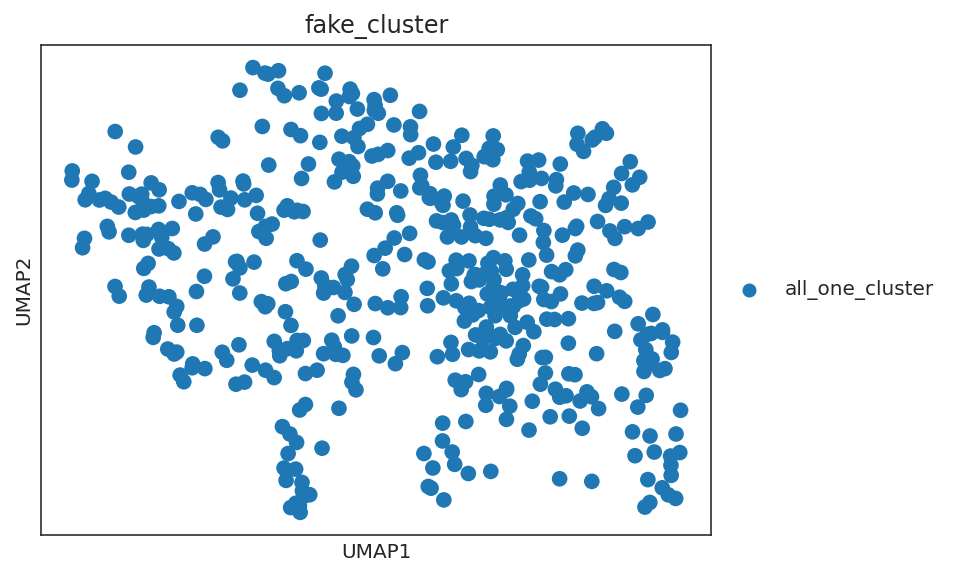

Working on results/cellTypeSpecificCellNetHg1332_v1/0.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZNF780A
AATF AATF ALX4 ALX4 ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR AR ARNT2 ARNT2 ASCL1 ASCL1 ATF2 ATF2 ATF3 ATF3 BACH1 BACH1 BANP BANP BARX2 BARX2 BLZF1 BLZF1 BMP4 BMP4 CBX2 CBX2 CCNE1 
Prediction failed for CCNE1 with error Gene CCNE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CCNE1 
Prediction failed for CCNE1 with error Gene CCNE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CDYL 
Prediction failed for CDYL with error Gene CDYL is not included in the base GRN; It is not TF

TCF4 TCF4 TCF7L2 TCF7L2 TEAD4 TEAD4 TFAP2A TFAP2A TFAP2B TFAP2B TFAP2C TFAP2C TFAP4 TFAP4 TFE3 TFE3 THAP1 THAP1 THAP11 THAP11 THAP7 THAP7 TLX3 TLX3 TP73 UBTF UBTF VAX1 VAX1 WRNIP1 
Prediction failed for WRNIP1 with error Gene WRNIP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
WRNIP1 
Prediction failed for WRNIP1 with error Gene WRNIP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
WT1 WT1 YBX1 YBX1 YY1 YY1 ZBED4 ZBED4 ZBTB3 ZBTB3 ZBTB33 ZBTB33 ZBTB7A ZFP57 ZFP57 ZIC1 ZIC1 ZKSCAN1 ZKSCAN1 ZMAT4 ZMAT4 ZMYND12 
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMYND12 
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.


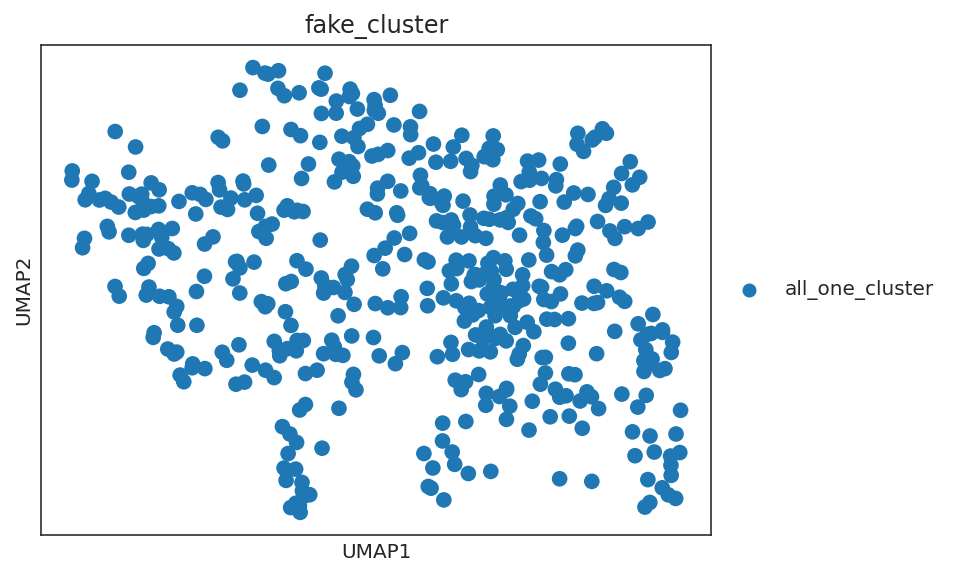

Working on results/cellTypeSpecificCellNetHg1332_v1/1.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/1429 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 1261 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 ANKRD22 AR 
Prediction failed for AR with error Gene AR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR 
Prediction failed for AR with error Gene AR is not included in the base GRN;

FLI1 FLI1 FOXA1 FOXA1 FOXB1 
Prediction failed for FOXB1 with error Gene FOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXB1 
Prediction failed for FOXB1 with error Gene FOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXC1 FOXC1 FOXD3 FOXD3 FOXD4L3 
Prediction failed for FOXD4L3 with error Gene FOXD4L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXD4L3 
Prediction failed for FOXD4L3 with error Gene FOXD4L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXG1 FOXG1 FOXH1 FOXH1 FOXL2 FOXL2 FOXM1 FOXM1 FOXO3 
Prediction failed for FOXO3 with error Gene FOXO3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXO3 
Prediction failed for FOXO3

NR2F2 NR2F2 NR5A1 
Prediction failed for NR5A1 with error Gene NR5A1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR5A1 
Prediction failed for NR5A1 with error Gene NR5A1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NRF1 
Prediction failed for NRF1 with error Gene NRF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NRF1 
Prediction failed for NRF1 with error Gene NRF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
OLIG1 OLIG1 OLIG2 OLIG2 OSTF1 OSTF1 OTX2 OTX2 OVOL2 OVOL2 PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 does not have enough regulatory connection in the G

WRNIP1 WRNIP1 WT1 WT1 YBX1 
Prediction failed for YBX1 with error Gene YBX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YBX1 
Prediction failed for YBX1 with error Gene YBX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YY1 
Prediction failed for YY1 with error Gene YY1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YY1 
Prediction failed for YY1 with error Gene YY1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBED4 ZBED4 ZBTB3 
Prediction failed for ZBTB3 with error Gene ZBTB3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ZBTB3 
Prediction failed for ZBTB3 with error Gene ZBTB3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
ZBTB33 
Predicti

PREB PREB PRICKLE1 SATB1 SATB1 SNAPC4 
Prediction failed for SNAPC4 with error Gene SNAPC4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAPC4 
Prediction failed for SNAPC4 with error Gene SNAPC4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF20 
Prediction failed for TCF20 with error Gene TCF20 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF20 
Prediction failed for TCF20 with error Gene TCF20 is not included in the base GRN; It is not TF 

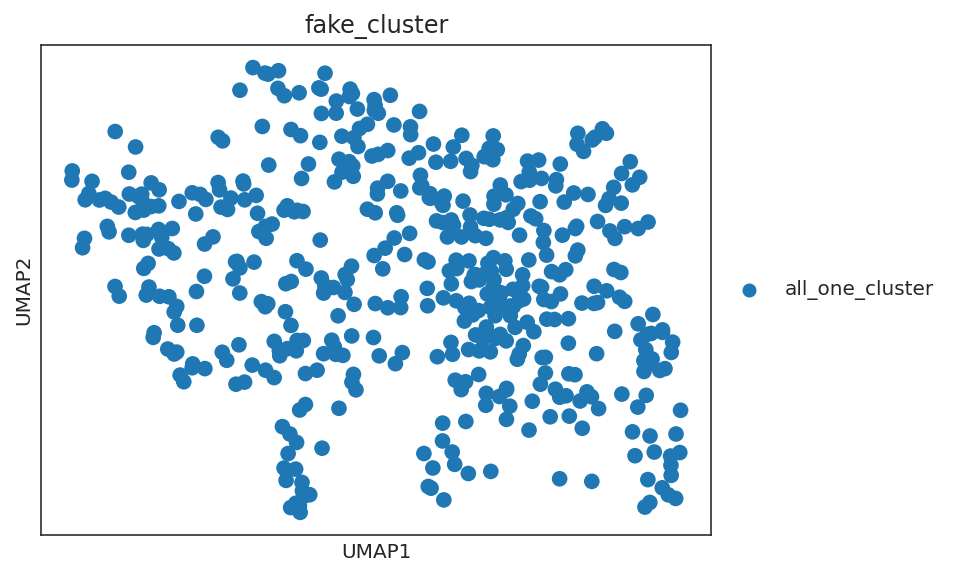

Working on results/cellTypeSpecificCellNetHg1332_v1/2.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/186 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 158 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

EGR2 EGR2 ELF4 
Prediction failed for ELF4 with error Gene ELF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESR1 
Prediction failed for ESR1 with error Gene ESR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot pe

NKX6-2 NKX6-2 NPAS2 
Prediction failed for NPAS2 with error Gene NPAS2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NPAS2 
Prediction failed for NPAS2 with error Gene NPAS2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR1D2 
Prediction failed for NR1D2 with error Gene NR1D2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR1D2 
Prediction failed for NR1D2 with error Gene NR1D2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR2C2 
Prediction failed for NR2C2 with error Gene NR2C2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR2C2 
Prediction failed for NR2C2 with error Gene NR2C2 is not included in the base GRN; It is not TF or TF motif information

SNAI2 SNAI2 SNAI3 
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI3 
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAPC1 
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAPC1 
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX11 
Prediction failed for SOX11 with error Gene SOX11 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX11 
Prediction failed for SOX11 with error Gene SOX11 is not included in the base GRN; It is not TF or TF motif informa

SATB1 SATB1 SNAPC4 
Prediction failed for SNAPC4 with error Gene SNAPC4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAPC4 
Prediction failed for SNAPC4 with error Gene SNAPC4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF20 
Prediction failed for TCF20 with error Gene TCF20 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF20 
Prediction failed for TCF20 with error Gene TCF20 is not included in the base GRN; It is not TF or TF motif informa

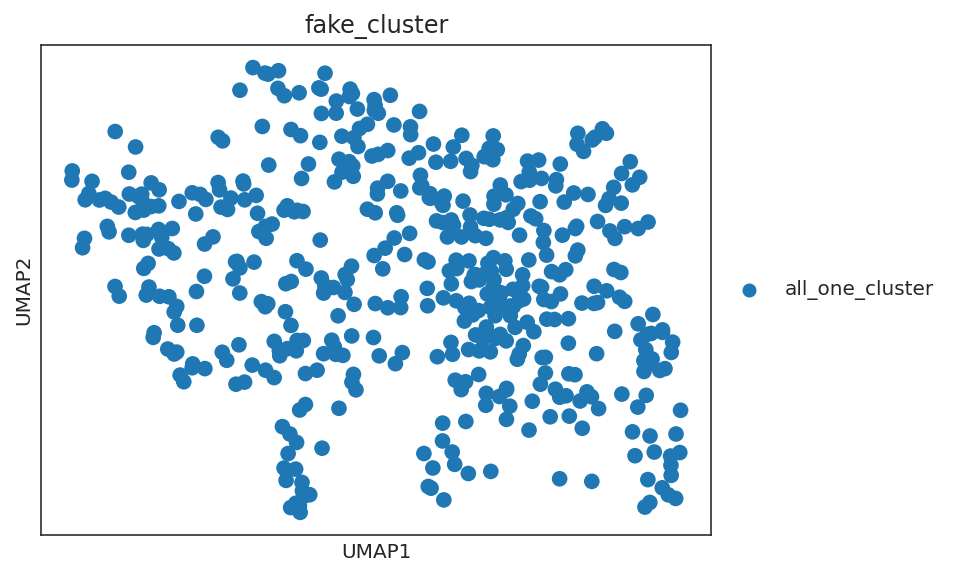

Working on results/cellTypeSpecificCellNetHg1332_v1/3.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/130 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 113 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

CUX1 CUX1 DLX2 
Prediction failed for DLX2 with error Gene DLX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX2 
Prediction failed for DLX2 with error Gene DLX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX3 
Prediction failed for DLX3 with error Gene DLX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX3 
Prediction failed for DLX3 with error Gene DLX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX5 
Prediction failed for DLX5 with error Gene DLX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX5 
Prediction failed for DLX5 with error Gene DLX5 is not included in the base GRN; It is not TF or TF motif information is not available. Can

FOXS1 FOXS1 GADD45A 
Prediction failed for GADD45A with error Gene GADD45A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GADD45A 
Prediction failed for GADD45A with error Gene GADD45A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA1 
Prediction failed for GATA1 with error Gene GATA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA1 
Prediction failed for GATA1 with error Gene GATA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GBX2 
Prediction failed for GBX2 with error Gene GBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GBX2 
Prediction failed for GBX2 with error Gene GBX2 is not included in the base GRN; It is not TF or TF motif informa

KLF2 KLF2 KLF3 
Prediction failed for KLF3 with error Gene KLF3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF3 
Prediction failed for KLF3 with error Gene KLF3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF4 
Prediction failed for KLF4 with error Gene KLF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF4 
Prediction failed for KLF4 with error Gene KLF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF8 
Prediction failed for KLF8 with error Gene KLF8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF8 
Prediction failed for KLF8 with error Gene KLF8 is not included in the base GRN; It is not TF or TF motif information is not available. Can

OSTF1 OSTF1 OTX2 
Prediction failed for OTX2 with error Gene OTX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
OTX2 
Prediction failed for OTX2 with error Gene OTX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
OVOL2 
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
OVOL2 
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not 

SIX1 SIX1 SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD1 
Prediction failed for SMAD1 with error Gene SMAD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD1 
Prediction failed for SMAD1 with error Gene SMAD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD3 
Prediction failed for SMAD3 with error Gene SMAD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD3 
Prediction failed for SMAD3 with error Gene SMAD3 is not included in the base GRN; It is not TF or TF motif information is not av

HOXA7 HOXA7 HOXC5 
Prediction failed for HOXC5 with error Gene HOXC5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXC5 
Prediction failed for HOXC5 with error Gene HOXC5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF6 
Prediction failed for KLF6 with error Gene KLF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF6 
Prediction failed for KLF6 with error Gene KLF6 is not included in the base GRN; It is not TF or TF motif information is not 

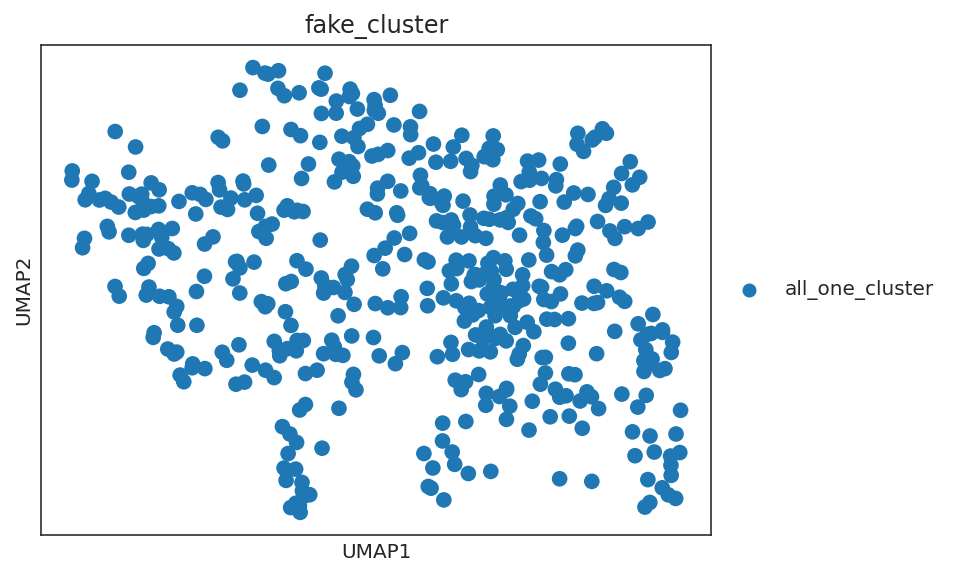

Working on results/cellTypeSpecificCellNetHg1332_v1/4.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/103 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 75 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in t

ESRRG ESRRG ESX1 
Prediction failed for ESX1 with error Gene ESX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESX1 
Prediction failed for ESX1 with error Gene ESX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETS1 
Prediction failed for ETS1 with error Gene ETS1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETS1 
Prediction failed for ETS1 with error Gene ETS1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETS2 
Prediction failed for ETS2 with error Gene ETS2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETS2 
Prediction failed for ETS2 with error Gene ETS2 is not included in the base GRN; It is not TF or TF motif information is not available. C

NEUROD1 NEUROD1 NEUROD2 NEUROD2 NEUROD6 NEUROD6 NFATC1 
Prediction failed for NFATC1 with error Gene NFATC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFATC1 
Prediction failed for NFATC1 with error Gene NFATC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFIB 
Prediction failed for NFIB with error Gene NFIB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFIB 
Prediction failed for NFIB with error Gene NFIB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFYB 
Prediction failed for NFYB with error Gene NFYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFYB 
Prediction failed for NFYB with error Gene NFYB is not included in the base GRN; It is no

RASL10A RASL10A REST 
Prediction failed for REST with error Gene REST is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
REST 
Prediction failed for REST with error Gene REST is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RFX2 
Prediction failed for RFX2 with error Gene RFX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RFX2 
Prediction failed for RFX2 with error Gene RFX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RFX5 
Prediction failed for RFX5 with error Gene RFX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RFX5 
Prediction failed for RFX5 with error Gene RFX5 is not included in the base GRN; It is not TF or TF motif information is not availabl

SOX2 SOX2 SOX5 
Prediction failed for SOX5 with error Gene SOX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX5 
Prediction failed for SOX5 with error Gene SOX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX6 
Prediction failed for SOX6 with error Gene SOX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX6 
Prediction failed for SOX6 with error Gene SOX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPI1 
Prediction failed for SPI1 with error Gene SPI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SPI1 
Prediction failed for SPI1 with error Gene SPI1 is not included in the base GRN; It is not TF or TF motif information is not available. Can

ZIC1 ZIC1 ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZKSCAN1 
Prediction failed for ZKSCAN1 with error Gene ZKSCAN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMAT4 
Prediction failed for ZMAT4 with error Gene ZMAT4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMAT4 
Prediction failed for ZMAT4 with error Gene ZMAT4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMYND12 
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZMYND12 
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or 

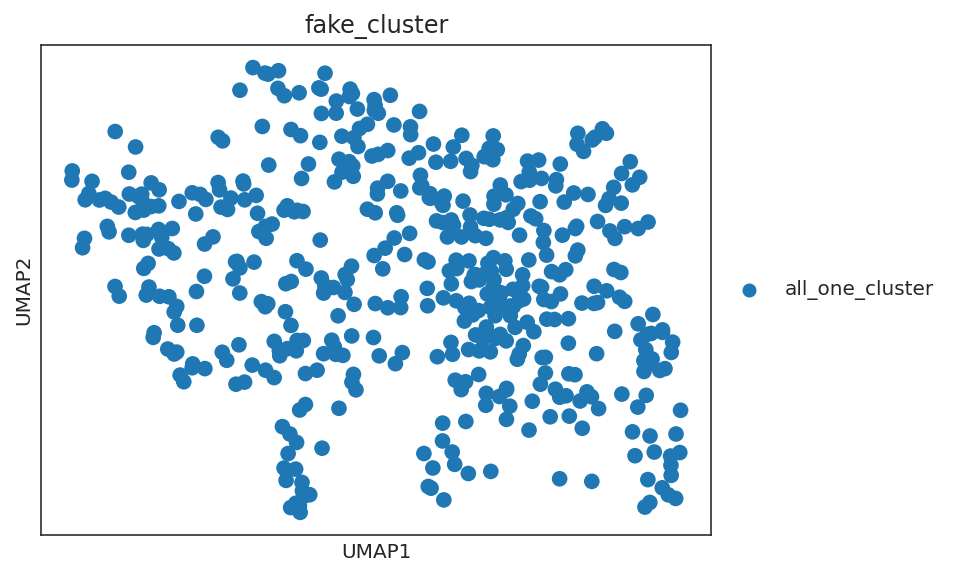

Working on results/cellTypeSpecificCellNetHg1332_v1/5.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/222 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 205 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

ELF4 ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESR1 
Prediction failed for ESR1 with error Gene ESR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESR1 
Prediction failed for ESR1 with error Gene ESR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform

FOXP1 FOXP1 FOXP1 FOXS1 
Prediction failed for FOXS1 with error Gene FOXS1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXS1 
Prediction failed for FOXS1 with error Gene FOXS1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GADD45A 
Prediction failed for GADD45A with error Gene GADD45A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GADD45A 
Prediction failed for GADD45A with error Gene GADD45A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA1 
Prediction failed for GATA1 with error Gene GATA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA1 
Prediction failed for GATA1 with error Gene GATA1 is not included in the base GRN; It is not TF or TF m

KLF2 KLF2 KLF3 
Prediction failed for KLF3 with error Gene KLF3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF3 
Prediction failed for KLF3 with error Gene KLF3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF4 
Prediction failed for KLF4 with error Gene KLF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF4 
Prediction failed for KLF4 with error Gene KLF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF8 KLF8 KLF9 
Prediction failed for KLF9 with error Gene KLF9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF9 
Prediction failed for KLF9 with error Gene KLF9 is not included in the base GRN; It is not TF or TF motif information is not avai

PAX5 PAX5 PBX1 PBX1 PDX1 
Prediction failed for PDX1 with error Gene PDX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PDX1 
Prediction failed for PDX1 with error Gene PDX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POLR3A 
Prediction failed for POLR3A with error Gene POLR3A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POLR3A 
Prediction failed for POLR3A with error Gene POLR3A is not included in the base GRN; It is not TF or TF motif

STAT4 STAT4 STAT5A STAT5A TAF7 
Prediction failed for TAF7 with error Gene TAF7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TAF7 
Prediction failed for TAF7 with error Gene TAF7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX5 
Prediction failed for TBX5 with error Gene TBX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX5 
Prediction failed for TBX5 with error Gene TBX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is no

E2F5 E2F5 ETV4 
Prediction failed for ETV4 with error Gene ETV4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV4 
Prediction failed for ETV4 with error Gene ETV4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOSB 
Prediction failed for FOSB with error Gene FOSB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOSB 
Prediction failed for FOSB with error Gene FOSB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXE1 
Prediction failed for FOXE1 with error Gene FOXE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXE1 
Prediction failed for FOXE1 with error Gene FOXE1 is not included in the base GRN; It is not TF or TF motif information is not availabl

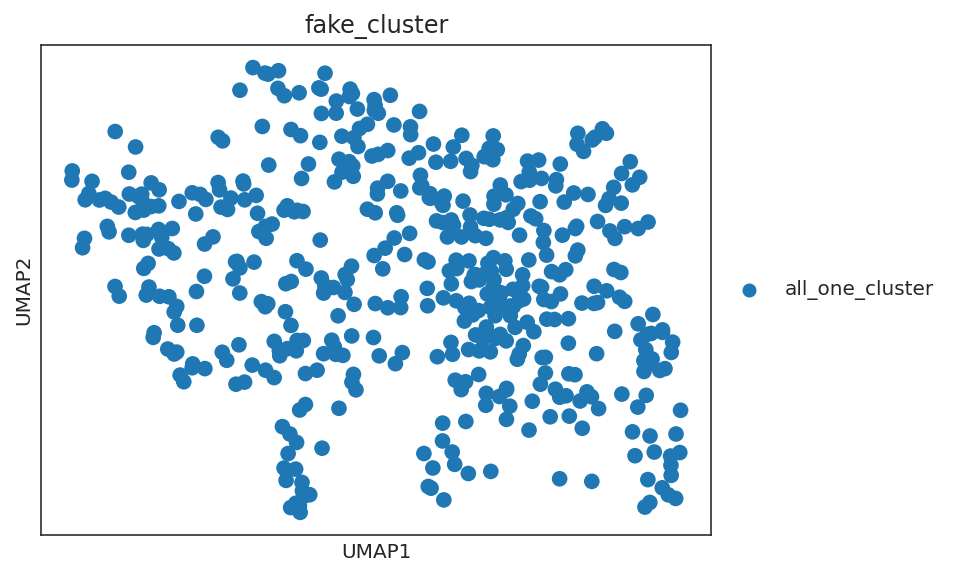

Working on results/cellTypeSpecificCellNetHg1332_v1/6.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/269 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 234 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

E2F7 E2F7 EGFLAM 
Prediction failed for EGFLAM with error Gene EGFLAM is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGFLAM 
Prediction failed for EGFLAM with error Gene EGFLAM is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGR1 
Prediction failed for EGR1 with error Gene EGR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGR1 
Prediction failed for EGR1 with error Gene EGR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGR2 
Prediction failed for EGR2 with error Gene EGR2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGR2 
Prediction failed for EGR2 with error Gene EGR2 is not included in the base GRN; It is not TF or TF motif information is not av

FOXH1 FOXH1 FOXL2 
Prediction failed for FOXL2 with error Gene FOXL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXL2 
Prediction failed for FOXL2 with error Gene FOXL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXM1 FOXM1 FOXO3 
Prediction failed for FOXO3 with error Gene FOXO3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXO3 
Prediction failed for FOXO3 with error Gene FOXO3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXP1 
Prediction failed for FOXP1 with error Gene FOXP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXP1 
Prediction failed for FOXP1 with error Gene FOXP1 is not included in the base GRN; It is not TF or TF motif i

KDM5B KDM5B KLF12 
Prediction failed for KLF12 with error Gene KLF12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF14 
Prediction failed for KLF14 with error Gene KLF14 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF14 
Prediction failed for KLF14 with error Gene KLF14 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF15 
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF15 
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF2 
Prediction failed for KLF2 with error Gene KLF2 is not included in the base GRN; It is not TF or TF motif information is n

OTX2 OTX2 OVOL2 
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
OVOL2 
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PATZ1 PATZ1 PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif informati

SMARCA4 SMARCA4 SMARCB1 
Prediction failed for SMARCB1 with error Gene SMARCB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMARCB1 
Prediction failed for SMARCB1 with error Gene SMARCB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI2 
Prediction failed for SNAI2 with error Gene SNAI2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI2 
Prediction failed for SNAI2 with error Gene SNAI2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI3 
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI3 
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF mot

ZBED4 ZBED4 ZBTB3 
Prediction failed for ZBTB3 with error Gene ZBTB3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB3 
Prediction failed for ZBTB3 with error Gene ZBTB3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB33 
Prediction failed for ZBTB33 with error Gene ZBTB33 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB33 
Prediction failed for ZBTB33 with error Gene ZBTB33 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB7A 
Prediction failed for ZBTB7A with error Gene ZBTB7A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZFP57 
Prediction failed for ZFP57 with error Gene ZFP57 is not included in the base GRN; It is not TF or TF motif info

HOXC5 HOXC5 IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF6 
Prediction failed for KLF6 with error Gene KLF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF6 
Prediction failed for KLF6 with error Gene KLF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MXD3 
Prediction failed for MXD3 with error Gene MXD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MXD3 
Prediction failed for MXD3 with error Gene MXD3 is not included in the base GRN; It is not TF or TF motif information is not availa

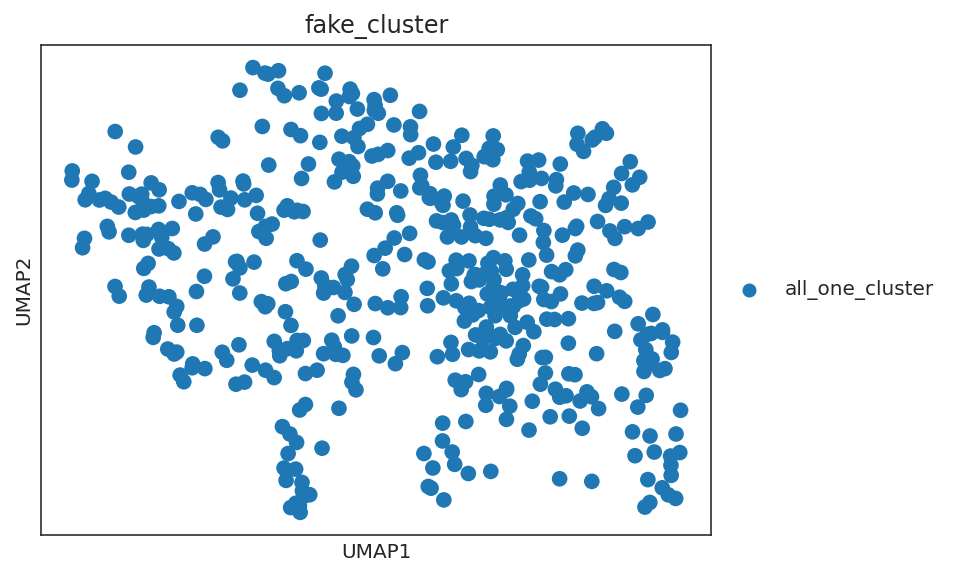

Working on results/cellTypeSpecificCellNetHg1332_v1/7.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/241 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 218 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

DLX2 DLX2 DLX3 
Prediction failed for DLX3 with error Gene DLX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX3 
Prediction failed for DLX3 with error Gene DLX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX5 
Prediction failed for DLX5 with error Gene DLX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX5 
Prediction failed for DLX5 with error Gene DLX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DVL2 
Prediction failed for DVL2 with error Gene DVL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DVL2 
Prediction failed for DVL2 with error Gene DVL2 is not included in the base GRN; It is not TF or TF motif information is not available. Can

FOXC1 FOXC1 FOXD3 
Prediction failed for FOXD3 with error Gene FOXD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXD3 
Prediction failed for FOXD3 with error Gene FOXD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXD4L3 
Prediction failed for FOXD4L3 with error Gene FOXD4L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXD4L3 
Prediction failed for FOXD4L3 with error Gene FOXD4L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXG1 
Prediction failed for FOXG1 with error Gene FOXG1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXG1 
Prediction failed for FOXG1 with error Gene FOXG1 is not included in the base GRN; It is not TF or TF motif i

JAG1 JAG1 JARID2 
Prediction failed for JARID2 with error Gene JARID2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JARID2 
Prediction failed for JARID2 with error Gene JARID2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JUNB 
Prediction failed for JUNB with error Gene JUNB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JUNB 
Prediction failed for JUNB with error Gene JUNB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JUNB 
Prediction failed for JUNB with error Gene JUNB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
JUND 
Prediction failed for JUND with error Gene JUND is not included in the base GRN; It is not TF or TF motif information is not av

NFIB NFIB NFYB 
Prediction failed for NFYB with error Gene NFYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFYB 
Prediction failed for NFYB with error Gene NFYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NKX2-1 
Prediction failed for NKX2-1 with error Gene NKX2-1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NKX2-1 
Prediction failed for NKX2-1 with error Gene NKX2-1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NKX6-1 
Prediction failed for NKX6-1 with error Gene NKX6-1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NKX6-1 
Prediction failed for NKX6-1 with error Gene NKX6-1 is not included in the base GRN; It is not TF or TF motif informati

PRDM1 PRDM1 RAD21 
Prediction failed for RAD21 with error Gene RAD21 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RAD21 
Prediction failed for RAD21 with error Gene RAD21 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RARG RARG RASL10A 
Prediction failed for RASL10A with error Gene RASL10A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
RASL10A 
Prediction failed for RASL10A with error Gene RASL10A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
REST 
Prediction failed for REST with error Gene REST is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
REST 
Prediction failed for REST with error Gene REST is not included in the base GRN; It is not TF or TF mot

TFAP2C TFAP2C TFAP4 
Prediction failed for TFAP4 with error Gene TFAP4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP4 
Prediction failed for TFAP4 with error Gene TFAP4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFE3 TFE3 THAP1 
Prediction failed for THAP1 with error Gene THAP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP1 
Prediction failed for THAP1 with error Gene THAP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP11 
Prediction failed for THAP11 with error Gene THAP11 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP11 
Prediction failed for THAP11 with error Gene THAP11 is not included in the base GRN; It is not TF or TF m

HES6 HES6 HLX 
Prediction failed for HLX with error Gene HLX is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HLX 
Prediction failed for HLX with error Gene HLX is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HNRNPD 
Prediction failed for HNRNPD with error Gene HNRNPD is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HNRNPD 
Prediction failed for HNRNPD with error Gene HNRNPD is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA7 
Prediction failed for HOXA7 with error Gene HOXA7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA7 
Prediction failed for HOXA7 with error Gene HOXA7 is not included in the base GRN; It is not TF or TF motif information is not av

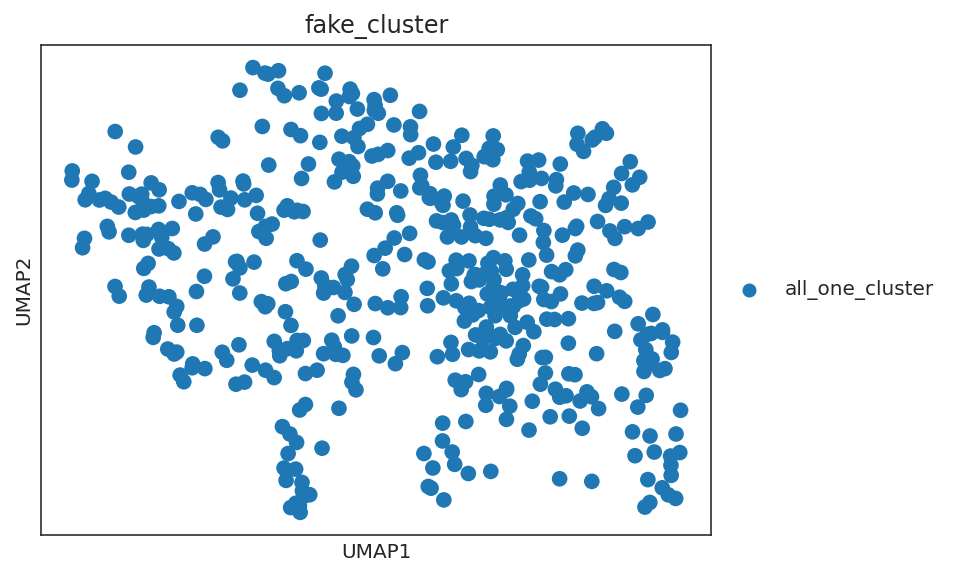

Working on results/cellTypeSpecificCellNetHg1332_v1/8.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/196 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 178 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

ELF4 ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESR1 
Prediction failed for ESR1 with error Gene ESR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESR1 
Prediction failed for ESR1 with error Gene ESR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform

FOXP1 FOXP1 FOXP1 FOXS1 
Prediction failed for FOXS1 with error Gene FOXS1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXS1 
Prediction failed for FOXS1 with error Gene FOXS1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GADD45A 
Prediction failed for GADD45A with error Gene GADD45A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GADD45A 
Prediction failed for GADD45A with error Gene GADD45A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA1 
Prediction failed for GATA1 with error Gene GATA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA1 
Prediction failed for GATA1 with error Gene GATA1 is not included in the base GRN; It is not TF or TF m

KLF2 KLF2 KLF3 
Prediction failed for KLF3 with error Gene KLF3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF3 
Prediction failed for KLF3 with error Gene KLF3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF4 
Prediction failed for KLF4 with error Gene KLF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF4 
Prediction failed for KLF4 with error Gene KLF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF8 
Prediction failed for KLF8 with error Gene KLF8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF8 
Prediction failed for KLF8 with error Gene KLF8 is not included in the base GRN; It is not TF or TF motif information is not available. Can

PAX5 PAX5 PBX1 PBX1 PDX1 
Prediction failed for PDX1 with error Gene PDX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PDX1 
Prediction failed for PDX1 with error Gene PDX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POLR3A 
Prediction failed for POLR3A with error Gene POLR3A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POLR3A 
Prediction failed for POLR3A with error Gene POLR3A is not included in the base GRN; It is not TF or TF motif

STAT4 STAT4 STAT5A STAT5A TAF7 
Prediction failed for TAF7 with error Gene TAF7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TAF7 
Prediction failed for TAF7 with error Gene TAF7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX5 
Prediction failed for TBX5 with error Gene TBX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX5 
Prediction failed for TBX5 with error Gene TBX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TBX6 
Prediction failed for TBX6 with error Gene TBX6 is not included in the base GRN; It is not TF or TF motif information is no

KLF6 KLF6 MXD3 
Prediction failed for MXD3 with error Gene MXD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MXD3 
Prediction failed for MXD3 with error Gene MXD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYCN 
Prediction failed for MYCN with error Gene MYCN is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYCN 
Prediction failed for MYCN with error Gene MYCN is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFIA 
Prediction failed for NFIA with error Gene NFIA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NFIA 
Prediction failed for NFIA with error Gene NFIA is not included in the base GRN; It is not TF or TF motif information is not available. Can

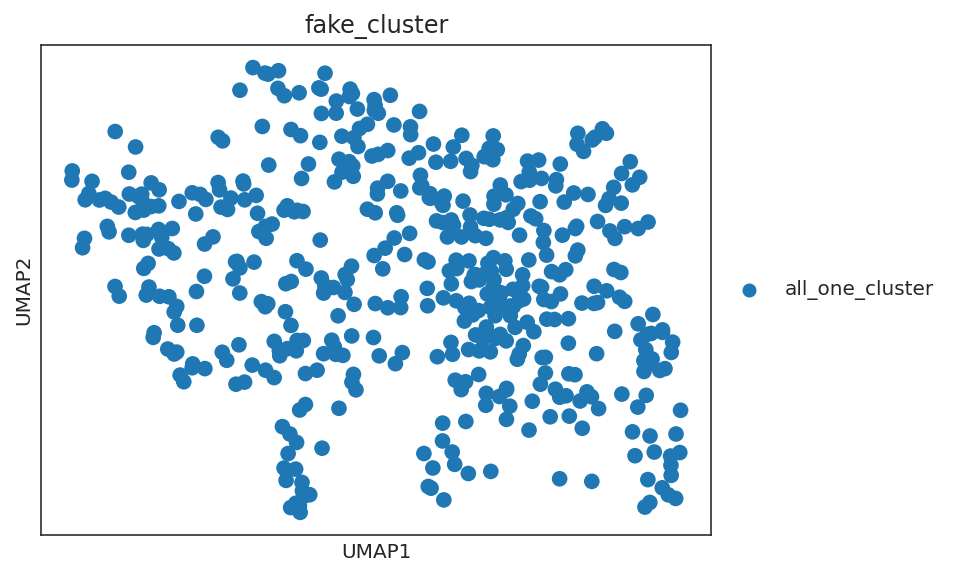

Working on results/cellTypeSpecificCellNetHg1332_v1/9.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.
Total number of TF was 39. Although we can go to the GRN calculation with this data, but the TF number is small.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/39 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 18 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in t

FBXO15 FBXO15 FEV 
Prediction failed for FEV with error Gene FEV is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FEV 
Prediction failed for FEV with error Gene FEV is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FIGLA 
Prediction failed for FIGLA with error Gene FIGLA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FIGLA 
Prediction failed for FIGLA with error Gene FIGLA is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FLI1 
Prediction failed for FLI1 with error Gene FLI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FLI1 
Prediction failed for FLI1 with error Gene FLI1 is not included in the base GRN; It is not TF or TF motif information is not available.

WT1 WT1 YBX1 
Prediction failed for YBX1 with error Gene YBX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YBX1 
Prediction failed for YBX1 with error Gene YBX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YY1 
Prediction failed for YY1 with error Gene YY1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YY1 
Prediction failed for YY1 with error Gene YY1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBED4 
Prediction failed for ZBED4 with error Gene ZBED4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBED4 
Prediction failed for ZBED4 with error Gene ZBED4 is not included in the base GRN; It is not TF or TF motif information is not available. Canno

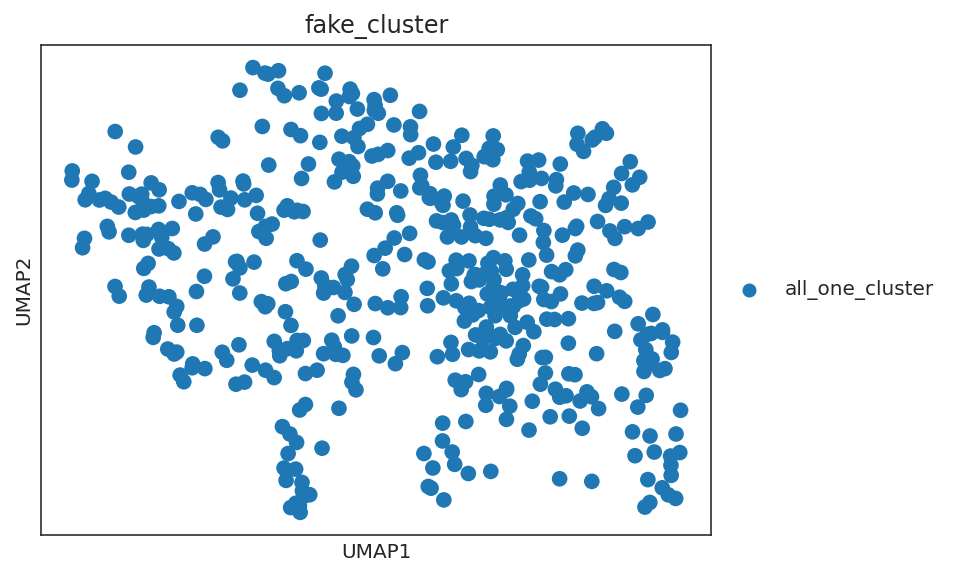

Working on results/cellTypeSpecificCellNetHg1332_v1/10.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/124 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 102 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

CUX1 CUX1 DLX2 
Prediction failed for DLX2 with error Gene DLX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX2 
Prediction failed for DLX2 with error Gene DLX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX3 
Prediction failed for DLX3 with error Gene DLX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX3 
Prediction failed for DLX3 with error Gene DLX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX5 
Prediction failed for DLX5 with error Gene DLX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DLX5 
Prediction failed for DLX5 with error Gene DLX5 is not included in the base GRN; It is not TF or TF motif information is not available. Can

FOXS1 FOXS1 GADD45A 
Prediction failed for GADD45A with error Gene GADD45A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GADD45A 
Prediction failed for GADD45A with error Gene GADD45A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA1 
Prediction failed for GATA1 with error Gene GATA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GATA1 
Prediction failed for GATA1 with error Gene GATA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GBX2 
Prediction failed for GBX2 with error Gene GBX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GBX2 
Prediction failed for GBX2 with error Gene GBX2 is not included in the base GRN; It is not TF or TF motif informa

LMO1 LMO1 MAB21L2 
Prediction failed for MAB21L2 with error Gene MAB21L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MAB21L2 
Prediction failed for MAB21L2 with error Gene MAB21L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MAB21L3 
Prediction failed for MAB21L3 with error Gene MAB21L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MAB21L3 
Prediction failed for MAB21L3 with error Gene MAB21L3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MEF2A 
Prediction failed for MEF2A with error Gene MEF2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MEF2A 
Prediction failed for MEF2A with error Gene MEF2A is not included in the base GRN; It is not TF or 

SIX1 SIX1 SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD1 
Prediction failed for SMAD1 with error Gene SMAD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD1 
Prediction failed for SMAD1 with error Gene SMAD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD3 
Prediction failed for SMAD3 with error Gene SMAD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD3 
Prediction failed for SMAD3 with error Gene SMAD3 is not included in the base GRN; It is not TF or TF motif information is not av

TEAD4 TEAD4 TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2B 
Prediction failed for TFAP2B with error Gene TFAP2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2B 
Prediction failed for TFAP2B with error Gene TFAP2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2C 
Prediction failed for TFAP2C with error Gene TFAP2C is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2C 
Prediction failed for TFAP2C with error Gene TFAP2C is not included in the base GRN; It is not TF or TF m

PREB PREB PRICKLE1 
Prediction failed for PRICKLE1 with error Gene PRICKLE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SATB1 SATB1 SNAPC4 
Prediction failed for SNAPC4 with error Gene SNAPC4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAPC4 
Prediction failed for SNAPC4 with error Gene SNAPC4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF15 
Prediction failed for TCF15 with error Gene TCF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF20 
Prediction failed for TCF20 with error Gene TCF20 is not included in the base GRN; It is not TF 

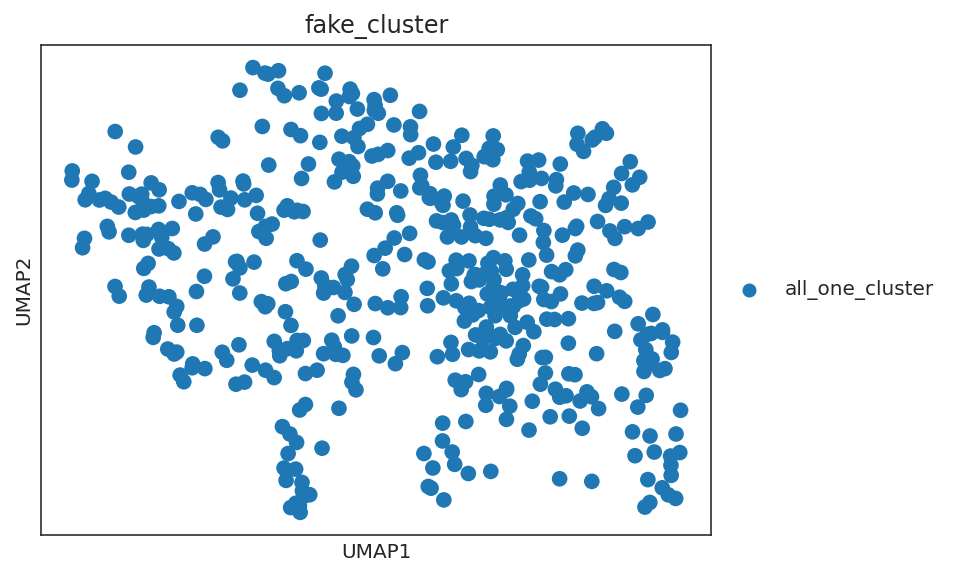

Working on results/cellTypeSpecificCellNetHg1332_v1/11.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/78 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 66 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in t

GRHL2 GRHL2 GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
H2AFZ 
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
H2AFZ 
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HDAC3 
Prediction failed for HDAC3 with error Gene HDAC3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HDAC3 
Prediction failed for HDAC3 with error Gene HDAC3 is not included in the base GRN; It is not TF or TF motif information i

NKX6-2 NKX6-2 NPAS2 
Prediction failed for NPAS2 with error Gene NPAS2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NPAS2 
Prediction failed for NPAS2 with error Gene NPAS2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR1D2 
Prediction failed for NR1D2 with error Gene NR1D2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR1D2 
Prediction failed for NR1D2 with error Gene NR1D2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR2C2 
Prediction failed for NR2C2 with error Gene NR2C2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
NR2C2 
Prediction failed for NR2C2 with error Gene NR2C2 is not included in the base GRN; It is not TF or TF motif information

SALL1 SALL1 SETDB1 
Prediction failed for SETDB1 with error Gene SETDB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SETDB1 
Prediction failed for SETDB1 with error Gene SETDB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX1 
Prediction failed for SIX1 with error Gene SIX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX1 
Prediction failed for SIX1 with error Gene SIX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included in the base GRN; It is not TF or TF motif information is not 

TCF4 TCF4 TCF7L2 
Prediction failed for TCF7L2 with error Gene TCF7L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TCF7L2 
Prediction failed for TCF7L2 with error Gene TCF7L2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TEAD4 
Prediction failed for TEAD4 with error Gene TEAD4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TEAD4 
Prediction failed for TEAD4 with error Gene TEAD4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP2A 
Prediction failed for TFAP2A with error Gene TFAP2A is not included in the base GRN; It is not TF or TF motif inf

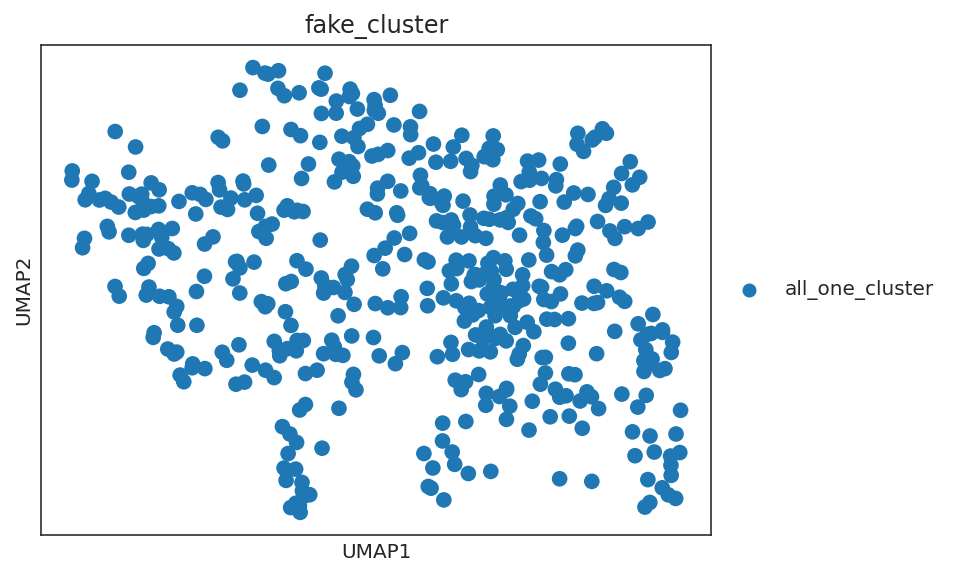

Working on results/cellTypeSpecificCellNetHg1332_v1/12.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/201 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 138 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

ETS2 ETS2 ETV2 
Prediction failed for ETV2 with error Gene ETV2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV2 
Prediction failed for ETV2 with error Gene ETV2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV3 
Prediction failed for ETV3 with error Gene ETV3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV3 
Prediction failed for ETV3 with error Gene ETV3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EVX1 
Prediction failed for EVX1 with error Gene EVX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EVX1 
Prediction failed for EVX1 with error Gene EVX1 is not included in the base GRN; It is not TF or TF motif information is not available. Can

HOXA10 HOXA10 HOXA2 HOXA2 HOXB1 
Prediction failed for HOXB1 with error Gene HOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXB1 
Prediction failed for HOXB1 with error Gene HOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXB3 HOXB3 HOXD1 HOXD1 HOXD10 
Prediction failed for HOXD10 with error Gene HOXD10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXD10 
Prediction failed for HOXD10 with error Gene HOXD10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXD3 
Prediction failed for HOXD3 with error Gene HOXD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXD3 
Prediction failed for HOXD3 with error Gene HOXD3 is not included in the base

MEIS1 MEIS1 MEIS2 
Prediction failed for MEIS2 with error Gene MEIS2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MEIS2 
Prediction failed for MEIS2 with error Gene MEIS2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYB 
Prediction failed for MYB with error Gene MYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYB 
Prediction failed for MYB with error Gene MYB is not included in the base GRN; It is not TF or TF motif information is not availa

RUNX3 RUNX3 SALL1 
Prediction failed for SALL1 with error Gene SALL1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SALL1 
Prediction failed for SALL1 with error Gene SALL1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SETDB1 
Prediction failed for SETDB1 with error Gene SETDB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SETDB1 
Prediction failed for SETDB1 with error Gene SETDB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX1 
Prediction failed for SIX1 with error Gene SIX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX1 
Prediction failed for SIX1 with error Gene SIX1 is not included in the base GRN; It is not TF or TF motif information i

BMP2 BMP2 BMP7 
Prediction failed for BMP7 with error Gene BMP7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
BMP7 
Prediction failed for BMP7 with error Gene BMP7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CDK9 
Prediction failed for CDK9 with error Gene CDK9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CDK9 
Prediction failed for CDK9 with error Gene CDK9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CITED1 
Prediction failed for CITED1 with error Gene CITED1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CITED1 
Prediction failed for CITED1 with error Gene CITED1 is not included in the base GRN; It is not TF or TF motif information is not av

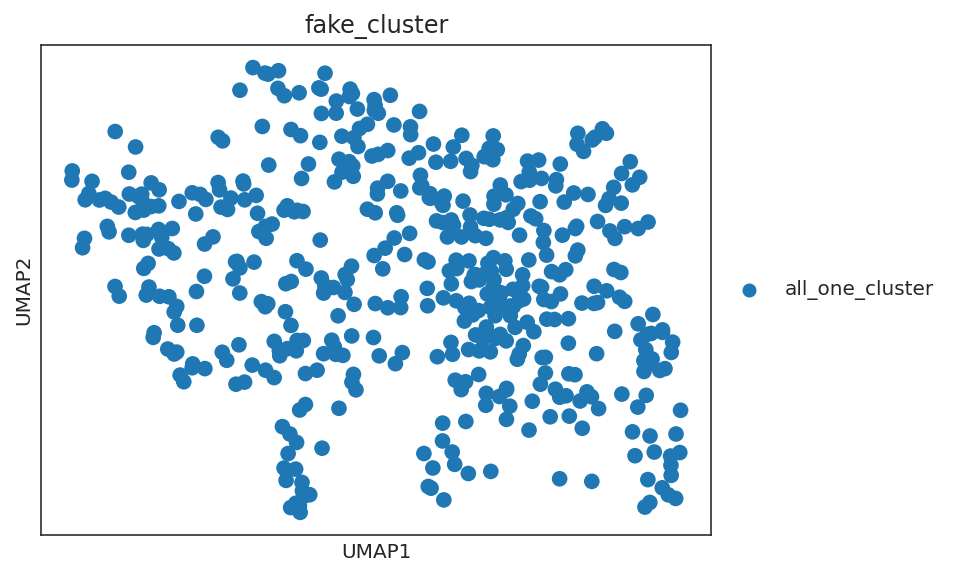

Working on results/cellTypeSpecificCellNetHg1332_v1/13.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/75 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 45 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in t

FOXA1 FOXA1 FOXB1 
Prediction failed for FOXB1 with error Gene FOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXB1 
Prediction failed for FOXB1 with error Gene FOXB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXC1 
Prediction failed for FOXC1 with error Gene FOXC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXC1 
Prediction failed for FOXC1 with error Gene FOXC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXD3 
Prediction failed for FOXD3 with error Gene FOXD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXD3 
Prediction failed for FOXD3 with error Gene FOXD3 is not included in the base GRN; It is not TF or TF motif information i

SALL1 SALL1 SETDB1 
Prediction failed for SETDB1 with error Gene SETDB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SETDB1 
Prediction failed for SETDB1 with error Gene SETDB1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX1 
Prediction failed for SIX1 with error Gene SIX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX1 
Prediction failed for SIX1 with error Gene SIX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SIX5 
Prediction failed for SIX5 with error Gene SIX5 is not included in the base GRN; It is not TF or TF motif information is not 

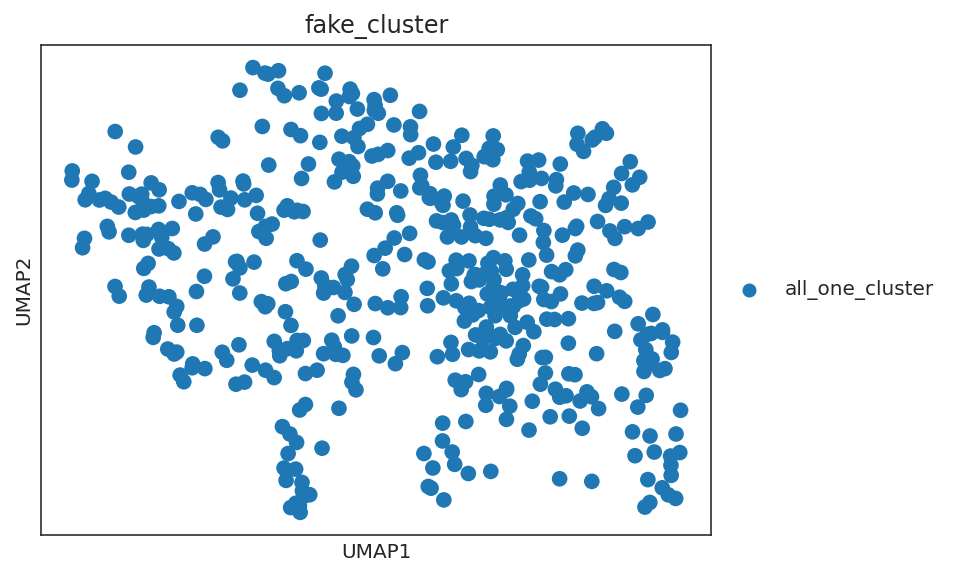

Working on results/cellTypeSpecificCellNetHg1332_v1/14.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/270 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 250 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

E2F7 E2F7 EGFLAM 
Prediction failed for EGFLAM with error Gene EGFLAM is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGFLAM 
Prediction failed for EGFLAM with error Gene EGFLAM is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGR1 
Prediction failed for EGR1 with error Gene EGR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGR1 
Prediction failed for EGR1 with error Gene EGR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGR2 
Prediction failed for EGR2 with error Gene EGR2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGR2 
Prediction failed for EGR2 with error Gene EGR2 is not included in the base GRN; It is not TF or TF motif information is not av

FOXM1 FOXM1 FOXO3 
Prediction failed for FOXO3 with error Gene FOXO3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXO3 
Prediction failed for FOXO3 with error Gene FOXO3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXP1 
Prediction failed for FOXP1 with error Gene FOXP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXP1 
Prediction failed for FOXP1 with error Gene FOXP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXP1 
Prediction failed for FOXP1 with error Gene FOXP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXS1 
Prediction failed for FOXS1 with error Gene FOXS1 is not included in the base GRN; It is not TF or TF motif information i

KDM5B KDM5B KLF12 
Prediction failed for KLF12 with error Gene KLF12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF14 
Prediction failed for KLF14 with error Gene KLF14 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF14 
Prediction failed for KLF14 with error Gene KLF14 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF15 
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF15 
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF2 
Prediction failed for KLF2 with error Gene KLF2 is not included in the base GRN; It is not TF or TF motif information is n

PATZ1 PATZ1 PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX5 
Prediction failed for PAX5 with error Gene PAX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX5 
Prediction failed for PAX5 with error Gene PAX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PBX1 PBX1 PDX1 
Prediction failed for PDX1 with error Gene PDX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PDX1 
Prediction failed for PDX1 with error Gene PDX1 is not included in the base GRN; It is not TF or TF motif information is not av

SMAD1 SMAD1 SMAD3 
Prediction failed for SMAD3 with error Gene SMAD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD3 
Prediction failed for SMAD3 with error Gene SMAD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD5 
Prediction failed for SMAD5 with error Gene SMAD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD7 
Prediction failed for SMAD7 with error Gene SMAD7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMAD7 
Prediction failed for SMAD7 with error Gene SMAD7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SMARCA4 SMARCA4 SMARCB1 
Prediction failed for SMARCB1 with error Gene SMARCB1 is not included in the base GRN; It is not TF or 

WRNIP1 WRNIP1 WT1 WT1 YBX1 
Prediction failed for YBX1 with error Gene YBX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YBX1 
Prediction failed for YBX1 with error Gene YBX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YY1 
Prediction failed for YY1 with error Gene YY1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
YY1 
Prediction failed for YY1 with error Gene YY1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBED4 ZBED4 ZBTB3 
Prediction failed for ZBTB3 with error Gene ZBTB3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ZBTB3 
Prediction failed for ZBTB3 with error Gene ZBTB3 is not included in the base GRN; It is not TF or TF motif informati

E2F5 E2F5 ETV4 
Prediction failed for ETV4 with error Gene ETV4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ETV4 
Prediction failed for ETV4 with error Gene ETV4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOSB 
Prediction failed for FOSB with error Gene FOSB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOSB 
Prediction failed for FOSB with error Gene FOSB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXE1 
Prediction failed for FOXE1 with error Gene FOXE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXE1 
Prediction failed for FOXE1 with error Gene FOXE1 is not included in the base GRN; It is not TF or TF motif information is not availabl

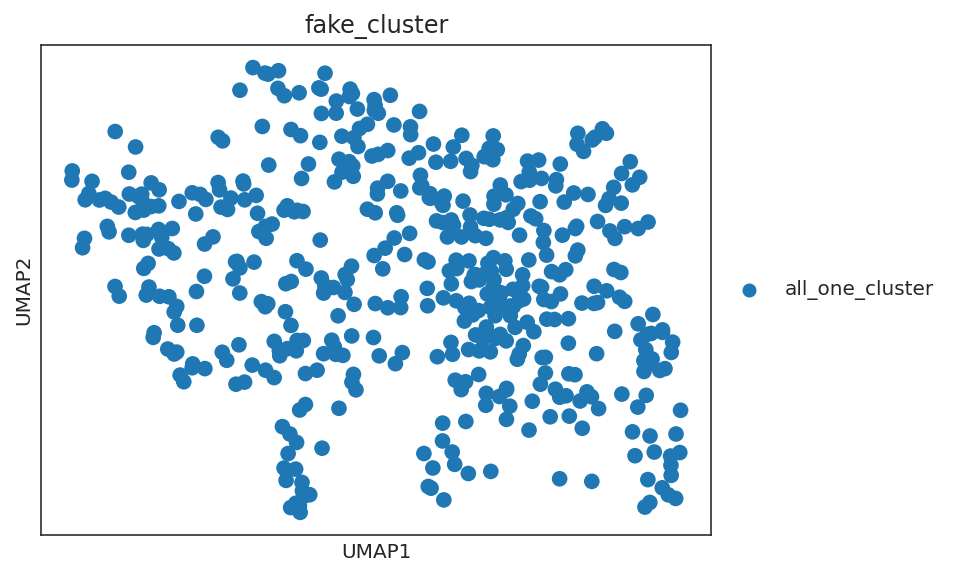

Working on results/cellTypeSpecificCellNetHg1332_v1/15.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/120 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 93 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in t

ELF4 ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESR1 
Prediction failed for ESR1 with error Gene ESR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESR1 
Prediction failed for ESR1 with error Gene ESR1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform

GRHL2 GRHL2 GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
GTF2B 
Prediction failed for GTF2B with error Gene GTF2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
H2AFZ 
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
H2AFZ 
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HDAC3 
Prediction failed for HDAC3 with error Gene HDAC3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HDAC3 
Prediction failed for HDAC3 with error Gene HDAC3 is not included in the base GRN; It is not TF or TF motif information i

KLF4 KLF4 KLF8 
Prediction failed for KLF8 with error Gene KLF8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF8 
Prediction failed for KLF8 with error Gene KLF8 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF9 
Prediction failed for KLF9 with error Gene KLF9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF9 
Prediction failed for KLF9 with error Gene KLF9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
LHX4 
Prediction failed for LHX4 with error Gene LHX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
LHX4 
Prediction failed for LHX4 with error Gene LHX4 is not included in the base GRN; It is not TF or TF motif information is not available. Can

OVOL2 OVOL2 PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PA2G4 
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PATZ1 
Prediction failed for PATZ1 with error Gene PATZ1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PATZ1 
Prediction failed for PATZ1 with error Gene PATZ1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PAX2 
Prediction failed for PAX2 with error Gene PAX2 is not included in the base GRN; It is not TF or TF motif information is not 

HOXA7 HOXA7 HOXC5 
Prediction failed for HOXC5 with error Gene HOXC5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXC5 
Prediction failed for HOXC5 with error Gene HOXC5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
IKZF5 
Prediction failed for IKZF5 with error Gene IKZF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF6 
Prediction failed for KLF6 with error Gene KLF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
KLF6 
Prediction failed for KLF6 with error Gene KLF6 is not included in the base GRN; It is not TF or TF motif information is not 

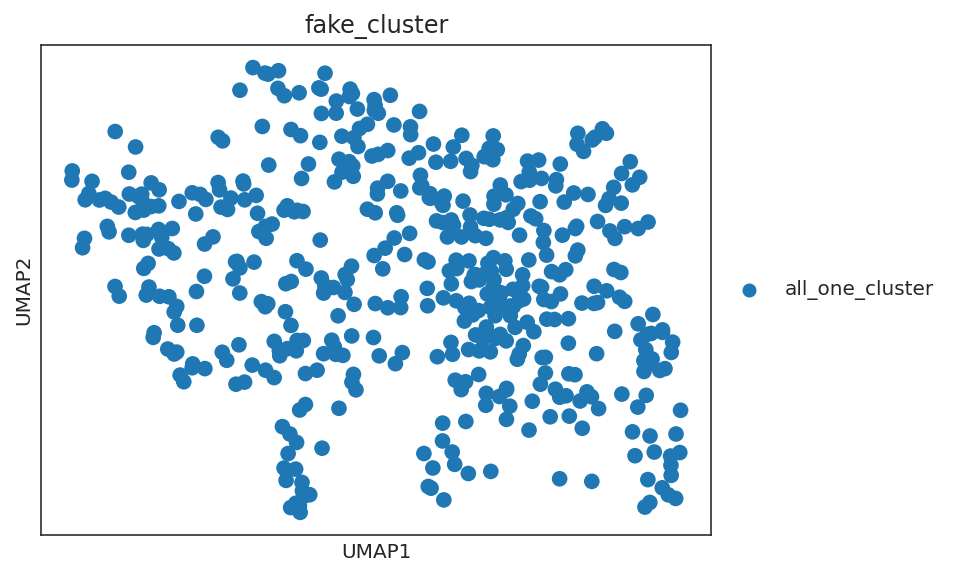

Working on results/cellTypeSpecificCellNetHg1332_v1/16.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/130 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 105 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in 

EGR1 EGR1 EGR2 EGR2 ELF4 
Prediction failed for ELF4 with error Gene ELF4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ELL2 
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EN1 
Prediction failed for EN1 with error Gene EN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ESR1 
Prediction failed for ESR1 with error Gene ESR1 is not included in the base GRN; It is not TF or TF motif information is not available.

HEY1 HEY1 HMGB2 
Prediction failed for HMGB2 with error Gene HMGB2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGB2 
Prediction failed for HMGB2 with error Gene HMGB2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HMGN1 
Prediction failed for HMGN1 with error Gene HMGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA10 
Prediction failed for HOXA10 with error Gene HOXA10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA10 
Prediction failed for HOXA10 with error Gene HOXA10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXA2 
Prediction failed for HOXA2 with error Gene HOXA2 is not included in the base GRN; It is not TF or TF motif informati

MEIS2 MEIS2 MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MSGN1 
Prediction failed for MSGN1 with error Gene MSGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYB 
Prediction failed for MYB with error Gene MYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYB 
Prediction failed for MYB with error Gene MYB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYF6 
Prediction failed for MYF6 with error Gene MYF6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
MYF6 
Prediction failed for MYF6 with error Gene MYF6 is not included in the base GRN; It is not TF or TF motif information is not available. C

PBX1 PBX1 PDX1 
Prediction failed for PDX1 with error Gene PDX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PDX1 
Prediction failed for PDX1 with error Gene PDX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
PHOX2B 
Prediction failed for PHOX2B with error Gene PHOX2B is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POLR3A 
Prediction failed for POLR3A with error Gene POLR3A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
POLR3A 
Prediction failed for POLR3A with error Gene POLR3A is not included in the base GRN; It is not TF or TF motif informati

SNAI2 SNAI2 SNAI3 
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAI3 
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAPC1 
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SNAPC1 
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX11 
Prediction failed for SOX11 with error Gene SOX11 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
SOX11 
Prediction failed for SOX11 with error Gene SOX11 is not included in the base GRN; It is not TF or TF motif informa

FOSB FOSB FOXE1 
Prediction failed for FOXE1 with error Gene FOXE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
FOXE1 
Prediction failed for FOXE1 with error Gene FOXE1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HES6 
Prediction failed for HES6 with error Gene HES6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HES6 
Prediction failed for HES6 with error Gene HES6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HLX 
Prediction failed for HLX with error Gene HLX is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HLX 
Prediction failed for HLX with error Gene HLX is not included in the base GRN; It is not TF or TF motif information is not available. Can

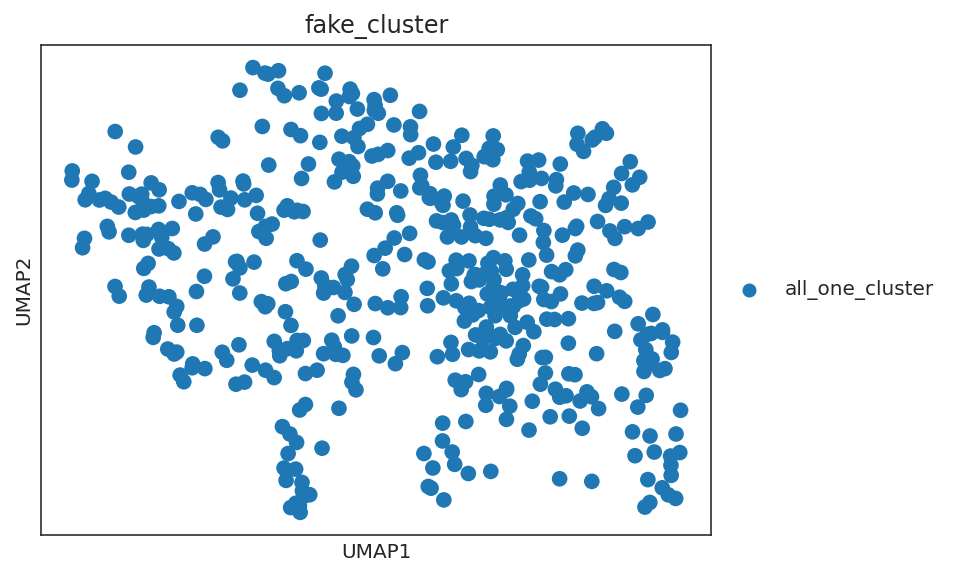

Working on results/cellTypeSpecificCellNetHg1332_v1/17.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.
Total number of TF was 41. Although we can go to the GRN calculation with this data, but the TF number is small.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/41 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 41 genes
Predicting ZNF780A
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AATF 
Prediction failed for AATF with error Gene AATF is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ALX4 
Prediction failed for ALX4 with error Gene ALX4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
ANKRD22 ANKRD22 AR 
Prediction failed for AR with error Gene AR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
AR 
Prediction failed for AR with error Gene AR is not included in the base GRN; I

DLX3 DLX3 DLX5 DLX5 DVL2 
Prediction failed for DVL2 with error Gene DVL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DVL2 
Prediction failed for DVL2 with error Gene DVL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
E2F7 
Prediction failed for E2F7 with error Gene E2F7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
E2F7 
Prediction failed for E2F7 with error Gene E2F7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGFLAM 
Prediction failed for EGFLAM with error Gene EGFLAM is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
EGFLAM 
Prediction failed for EGFLAM with error Gene EGFLAM is not included in the base GRN; It is not TF or TF motif information

HOXB3 HOXB3 HOXD1 
Prediction failed for HOXD1 with error Gene HOXD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXD1 
Prediction failed for HOXD1 with error Gene HOXD1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXD10 
Prediction failed for HOXD10 with error Gene HOXD10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXD10 
Prediction failed for HOXD10 with error Gene HOXD10 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXD3 
Prediction failed for HOXD3 with error Gene HOXD3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
HOXD3 
Prediction failed for HOXD3 with error Gene HOXD3 is not included in the base GRN; It is not TF or TF motif informa

TFAP2A TFAP2A TFAP2B TFAP2B TFAP2C TFAP2C TFAP4 
Prediction failed for TFAP4 with error Gene TFAP4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFAP4 
Prediction failed for TFAP4 with error Gene TFAP4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFE3 
Prediction failed for TFE3 with error Gene TFE3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
TFE3 
Prediction failed for TFE3 with error Gene TFE3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP1 
Prediction failed for THAP1 with error Gene THAP1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
THAP1 
Prediction failed for THAP1 with error Gene THAP1 is not included in the base GRN; It is not TF o

BMP7 BMP7 CDK9 
Prediction failed for CDK9 with error Gene CDK9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CDK9 
Prediction failed for CDK9 with error Gene CDK9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CITED1 
Prediction failed for CITED1 with error Gene CITED1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
CITED1 
Prediction failed for CITED1 with error Gene CITED1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DBX1 
Prediction failed for DBX1 with error Gene DBX1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
DBX1 
Prediction failed for DBX1 with error Gene DBX1 is not included in the base GRN; It is not TF or TF motif information is not av

In [18]:
predictions = {
    i: evaluator.trainCausalModelAndPredict(expression=ko_lab_esc_data_train,
                                  baseNetwork=networks[experiments.loc[i,'network']],
                                  memoizationName="results/" + EXPERIMENT_NAME + "/" + str(i) + ".celloracle.oracle", 
                                  perturbations=perturbationsToPredict,
                                  clusterColumnName = "fake_cluster",
                                  pruningParameters = {"p":experiments.loc[i,'p'], 
                                                       "threshold_number":experiments.loc[i,'threshold_number']}) 
    for i in experiments.index
}


In [19]:
predictions[0]

{'AATF': ArrayView([0.27568942, 0.23012871, 0.37785624, ..., 0.45200345,
            0.28904257, 1.08334396]),
 'ALX4': ArrayView([0.31202626, 0.26772755, 0.35414025, ..., 0.50812494,
            0.28083417, 1.06990334]),
 'ANKRD22': nan,
 'AR': ArrayView([0.32489342, 0.24806546, 0.34466011, ..., 0.51262971,
            0.28558083, 1.06840411]),
 'ARNT2': ArrayView([0.2902298 , 0.26253468, 0.34020905, ..., 0.48275219,
            0.28420888, 1.07157948]),
 'ASCL1': ArrayView([0.31381653, 0.25748635, 0.34983349, ..., 0.51091643,
            0.28067911, 1.07346243]),
 'ATF2': ArrayView([0.31319448, 0.25476364, 0.35460063, ..., 0.49875789,
            0.29479125, 1.06028168]),
 'ATF3': ArrayView([0.35382409, 0.24855983, 0.41687748, ..., 0.46796604,
            0.25005638, 1.05439823]),
 'BACH1': ArrayView([0.31492068, 0.24197711, 0.36505321, ..., 0.49591153,
            0.28446039, 1.05246314]),
 'BANP': ArrayView([0.29714785, 0.25212139, 0.35349605, ..., 0.49920444,
            0.2684161

### Evaluation

We compute the correlation of the predictions with held-out perturbations.

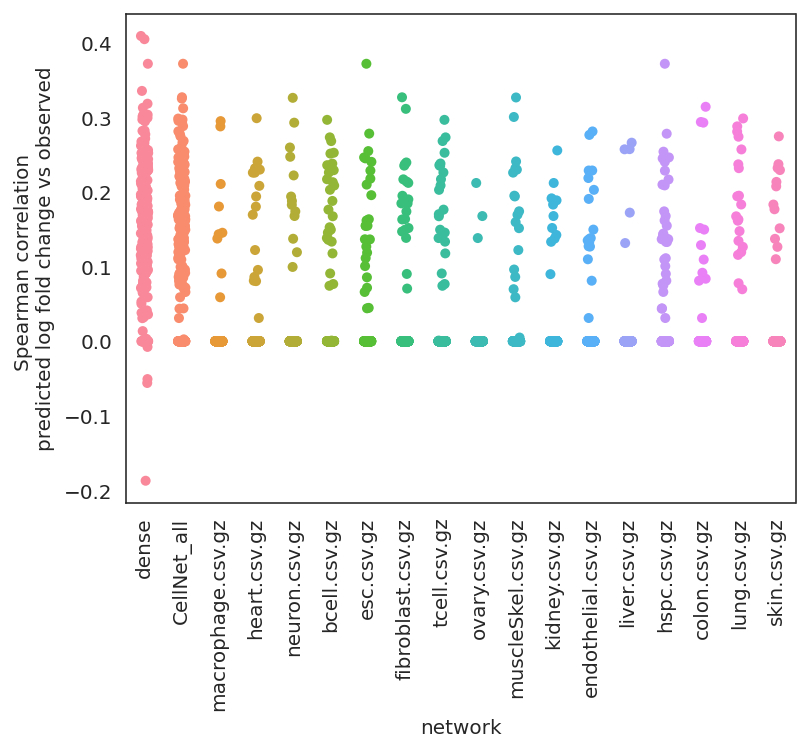

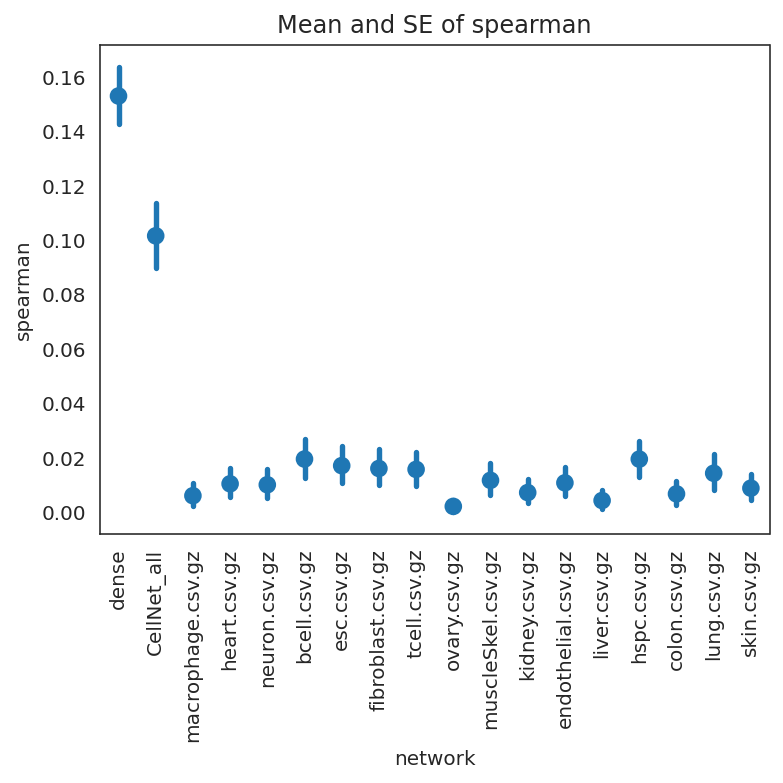

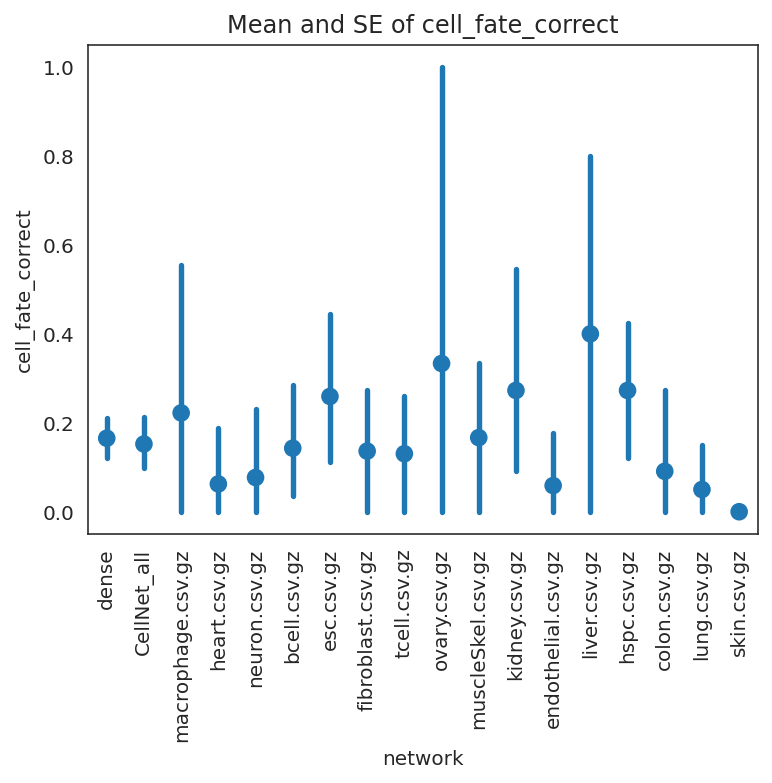

(      spearman     spearmanp  cell_fate_correct perturbation  index  \
 0     0.186260  9.488955e-22                0.0         AATF      0   
 1     0.183768  3.328818e-21                0.0         ALX4      0   
 2     0.000000  1.000000e+00                NaN      ANKRD22      0   
 3     0.201054  3.821110e-25                0.0           AR      0   
 4     0.194263  1.495010e-23                0.0        ARNT2      0   
 ...        ...           ...                ...          ...    ...   
 4729  0.000000  1.000000e+00                NaN        ZMAT5     17   
 4730  0.000000  1.000000e+00                NaN       ZNF384     17   
 4731  0.000000  1.000000e+00                NaN       ZNF480     17   
 4732  0.000000  1.000000e+00                NaN        ZNF74     17   
 4733  0.000000  1.000000e+00                NaN      ZNF780A     17   
 
           network  p  threshold_number pruning  somePredictionRefused  
 0           dense  1         102313295    none              

<Figure size 432x324 with 0 Axes>

In [20]:
controlIndex = ko_lab_esc_data_train.obs["perturbation"]=="Control"
evaluator.evaluateCausalModel(heldout = ko_lab_esc_data_heldout, 
                    predictions = predictions,   
                    baseline = ko_lab_esc_data_train[controlIndex,:].X.mean(axis=0), 
                    classifier=cellFateClassifier, 
                    experiments = experiments,
                    factor_varied = "network",
                    experiment_name = EXPERIMENT_NAME)